In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from csv import reader
import os
import re
import spectral
from scipy.signal import argrelextrema
from scipy.ndimage import median_filter
from pysptools.spectro import convex_hull_removal
import spectral.io.envi as envi
import pickle

In [4]:
#import required package
from __future__ import division
from scipy import interpolate
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import spectral.io.envi as envi
from spectral import *
import os
import re
import math
import PIL
from scipy import signal
from scipy import ndimage
from scipy import spatial
from scipy import stats
from scipy import interpolate
import traceback
import sys
import pickle
import warnings
import pandas as pd
from pprint import pprint
from sklearn.metrics import r2_score
from PIL import Image
from IPython.core.display import display, HTML
import cv2
from os import listdir

In [5]:
#file mangement generates a list containing a pth to all hdr files of pre-processed observations
def get_all_processed_HDR_addresses(parentDirectory):
    observationFiles=[]
    
    for (dirpath, dirnames, filenames) in os.walk(parentDirectory):
        observationFiles.extend(filenames)
        break
    ObservationImageAddresses=[]
    
    hdrPattern=".hdr"
    for i in observationFiles:
        if re.search(hdrPattern,i):
            ObservationImageAddresses.append(parentDirectory+'/'+i)
    return ObservationImageAddresses

In [6]:
#read hrd files for wavlengths of all bands
def read_CRISM_Image_wavelengths(headerFileAddress):
    wavelengthFile="J:/IIT/user/Documents/CRISM Multispectral Exploration/Processed_observations/wavelength_list.txt"
    
    currentObservationHeader=envi.open(headerFileAddress)
    currentObservationImage=currentObservationHeader.open_memmap()
    currentObservationArray=np.array(currentObservationImage)
    #currentObservationArray=spectral.open_image(i)

    #read wavelengths from saved wavelength file
    with open (wavelengthFile, 'rb') as fp:
        wavelengthsOfCurrentObservation=pickle.load(fp)
    return currentObservationArray,wavelengthsOfCurrentObservation

In [7]:
#find index of wavelngth closest to given wavelength
def find_nearest(wavelength_list,value): #find wavelength value in list closest to given value
    idx = np.searchsorted(wavelength_list, value, side="left")
    if idx > 0 and (idx == len(wavelength_list) or math.fabs(value - wavelength_list[idx-1]) < math.fabs(value - wavelength_list[idx])):
        return wavelength_list[idx-1]
    else:
        return wavelength_list[idx]

def find_wavelength_index(wavelength_list,item): #return index of in the array
    first = 0
    last = len(wavelength_list)-1
    found = False
    while( first<=last and not found):
        mid = (first + last)//2
        if wavelength_list[mid] == item :
            found = True
        else:
            if item < wavelength_list[mid]:
                last = mid - 1
            else:
                first = mid + 1	
    return mid
def find_nearest_index(wavelength_list,wavelength): #get wavelength in index closest to gicen wavelength and return its index
    (nearest_index,nearest_wavelength)=min(enumerate(wavelength_list), key=lambda x: abs(x[1]-wavelength))
    return nearest_index
def find_nearest_index_for_list(wavelength_list,wavelengths): # find index of nearest value for a list of given values
    indices=[]
    for i in wavelengths:
        indices.append(find_nearest_index(wavelength_list,i))
    return indices

In [8]:
# given a hyperspectral datacube and wavelengths to serve as upper and lower thresholds subset the datacube along the spectral direction
def get_spectral_subset(datacube,wavelength_list,lower_threshold,upper_threshold): #returns spectral subset from lower to upper threshold ( 1.2 to 2.6 micrometer for CRISM IR)
    lower_threshold_index=find_wavelength_index(wavelength_list,lower_threshold)
    upper_threshold_index=find_wavelength_index(wavelength_list,upper_threshold)
    thresholdedDatacube=datacube[:,:,lower_threshold_index:upper_threshold_index+1]
    thresholdedWavelengthList=wavelength_list[lower_threshold_index:upper_threshold_index+1]
    return thresholdedDatacube,thresholdedWavelengthList

In [9]:
# return an array of objects of SLI files corresponding to different mineral spectra
def getspectralObjects(spectraDirectory):
    observationFiles=[]
    for (_,_,temporaryList) in os.walk(spectraDirectory):
        observationFiles.extend(temporaryList)
        break
    hdrPattern=".hdr$"
    spectralObjects=[]
    for i in observationFiles:
        if re.search(hdrPattern,i):
            currentFile=spectraDirectory+'/'+i
            currentSpectra=envi.open(currentFile)
            spectralObjects.append(currentSpectra)
    return spectralObjects,observationFiles

In [10]:
#given a spectral object and a wavelength list extract spectra resample them to the given wavelenght list resolution
def getResampledSpectra(spectralObject,wavelengthList):
    #read an NxM numpy array containing N spectra with M bands
    spectras=spectralObject.spectra 
    #read an array with wavelengths corresponding to each band
    sourceWavelengthList=spectralObject.bands.centers 
    #find no of bands in CRISM image
    noOfBands=np.shape(wavelengthList)[0] 
    # calculate number of spectras
    noOfSpectra=np.shape(spectras)[0]
    # create an array to store the resampled spectras
    resampledSpectras=np.zeros((noOfSpectra,noOfBands))
    #create a resampler
    resampler=BandResampler(sourceWavelengthList,wavelengthList)
    #iterate over all spectra
    for i in range(noOfSpectra):
        #resample a spectra
        resampledSpectras[i,:]=resampler(spectras[i,:])
    return resampledSpectras,spectralObject.names

In [11]:
#given spectral object get original spectra and accompaning wavelength list
def getOriginalSpectra(spectralObject):
    #read an NxM numpy array containing N spectra with M bands
    spectras=spectralObject.spectra 
    #read an array with wavelengths corresponding to each band
    sourceWavelengthList=spectralObject.bands.centers 
    
    return spectras,spectralObject.names,sourceWavelengthList

In [12]:
# threshold image at 2.6 micrometer
def preProcessImage(imageHeaderAddress): # given address of a CRISM header file, read the data, deal with NaN values and apply spectral subset
    datacube,wavelength_list=read_CRISM_Image_wavelengths(imageHeaderAddress) #read image and wavelength_list
    datacube=np.where(np.logical_and(datacube>0,datacube<1),datacube,0)
    lower_threshold_for_spectral_subset=1.0
    upper_threshold_for_spectral_subset=2.59 #define wavelength threshold (CRISM data too noisy post 2.6 micrometer)
    datacube,wavelength_list=get_spectral_subset(datacube,wavelength_list,lower_threshold_for_spectral_subset,upper_threshold_for_spectral_subset)
    return datacube,wavelength_list

In [13]:
#calculate mean relfectance at wavelength with defined kernel size for datacube
def calcualteReflectaneAtWavelength(wavelength,kernelSize):
    global slicedCube
    global wavelengthList
    targetWavelength=find_nearest(wavelengthList,wavelength) #find nearest wavelength value in list
    targetWavelengthIndex=find_nearest_index(wavelengthList,wavelength) 
    BandAtWavelength=slicedCube[:,:,targetWavelengthIndex]
    for i in range(targetWavelengthIndex-math.floor(kernelSize/2),targetWavelengthIndex+math.floor(kernelSize/2)):
        BandAtWavelength=np.add(slicedCube[:,:,i],BandAtWavelength)
    BandAtWavelength=np.subtract(BandAtWavelength,slicedCube[:,:,targetWavelengthIndex])
    return BandAtWavelength/kernelSize

In [14]:
#given a spectra apply a DoG(difference of gaussian) filter to the spectra with sigmas 7 and 4
def applyDoG(spectra,sigma1,sigma2):
    #specify the two sigmas
    #sigma1=9
    #sigma2=3
    #apply gaussian filter with the first sigma
    gauss1Filtered=ndimage.gaussian_filter1d(spectra,sigma=sigma1)
    #apply gaussian filter with the second sigma
    gauss2Filtered=ndimage.gaussian_filter1d(spectra,sigma=sigma2)
    #calculate DoG
    differenceSpectra=np.abs(np.subtract(gauss2Filtered,gauss1Filtered))
    return differenceSpectra

In [15]:
#given the spectra and indices of minimas interpolate leniar segmaents between the minimas
def interpolateBetweenIndices(spectra,indices):
    global wavelengthList
    #create linear interpolator using wavelengths and reflectance at minima indices
    interpolator=interpolate.interp1d(wavelengthList[indices],spectra[indices],kind='linear')
    #get interpolated values at all indices
    interpolatedReflectance=interpolator(wavelengthList)
    return interpolatedReflectance

In [16]:
#given a spectra and fraction size apply a boxcar (moving average) filter of that size to the spectra
def applyBoxcarFilter(spectra,filterFraction):
    #get number of bands in the spectra
    bands=np.shape(spectra)[0]
    #compute size of the filter
    filterSize=int(math.floor(filterFraction*bands))
    #cimpute half filter size
    halfFilterSize=int(math.floor(filterSize/2))
    #symetrically pad the spectra with half the filter size on each end
    paddedSpectra=np.pad(spectra,pad_width=halfFilterSize,mode='symmetric')
    #create an empty array to store the filtered spectra
    filteredSpectra=np.zeros_like(spectra)
    #create a counter to store filtered value
    index=0
    #iterate in original spectra range  in the padded spectra
    for i in range(halfFilterSize,halfFilterSize+bands):
        #apply the filter and store the result
        filteredSpectra[index]=np.sum(paddedSpectra[i-halfFilterSize:i+halfFilterSize])/filterSize
        #increment the counter
        index=index+1
    return filteredSpectra

In [17]:
#given a signal and size of filter find the standard deviation signal
def getStandardDeviation(signal,windowSize):
    c1=ndimage.uniform_filter(signal,windowSize, mode='reflect')
    c2=ndimage.uniform_filter(signal*signal,windowSize, mode='reflect')
    return np.sqrt(c2 - c1*c1)

In [18]:
#given a signal smmoth it adaptively
def adaptiveSmoothing(signal):
    #specify box car filter sizes 2% and 10%
    firstBoxCarSize=0.05
    secondBoxCarSize=0.15
    #specify the sigma and window fraction
    fraction1=1/15
    fraction2=1/25
    #specify the standard deviation for the diffrence of Gaussian filters
    sigma1=15
    sigma2=4
    #specify window size of standard deviation calculation
    stdWindowSize1=int(fraction1*np.shape(signal)[0])
    stdWindowSize2=int(fraction2*np.shape(signal)[0])
    #apply 2% box car filter twice
    boxcar2Spectra=applyBoxcarFilter(applyBoxcarFilter(signal,filterFraction=firstBoxCarSize),filterFraction=firstBoxCarSize)
    #apply 10% box car filter twice
    boxcar10Spectra=applyBoxcarFilter(applyBoxcarFilter(signal,filterFraction=firstBoxCarSize),filterFraction=firstBoxCarSize)
    #apply DoG on 2% box car
    dog2Spectra=applyDoG(boxcar2Spectra,sigma1,sigma2)
    #apply DoG on 10% box car
    dog10Spectra=applyDoG(boxcar10Spectra,sigma1,sigma2)
    #calculate standard deviation for both dog results
    dog2STD=getStandardDeviation(dog2Spectra,stdWindowSize1)
    dog10STD=getStandardDeviation(dog10Spectra,stdWindowSize2)
    #get smmothed spectra
    smothedSpectra=np.where(dog2STD<dog10STD,boxcar2Spectra,boxcar10Spectra)
    return smothedSpectra

In [19]:
#given a spectra normalize it to the range (0,1)
def normalizeSpectra(spectra):
    #spectra/=np.max(np.abs(spectra),axis=0)
    #return spectra
    return (spectra - np.min(spectra))/np.ptp(spectra)

In [20]:
#given a spectra and the indices of local minimas find the maximas for each segment demarkated by two minimas
def getMaximas(spectra,minimaIndices):
    #add the end of the spectra to the list of minimas and sort
    minimaIndices.append(len(spectra)-1)
    minimaIndices.sort()
    #create an empty list to store maximas
    maximaIndices=[]
    #iterate from 1st to the penultimate element
    for i in range(len(minimaIndices)-1):
        #extract slice of the spectra
        spectralSlice=list(spectra[minimaIndices[i]:minimaIndices[i+1]])
        #extract slice of the hull
        #append the maxima in this segment to the list of maximas
        try:
            maximaIndices.append(spectralSlice.index(max(spectralSlice))+minimaIndices[i])
        except:
            pass
    return maximaIndices

In [21]:
#given a spectra and a hull for the spectra return pait indices marking areas of the spectra that rise aboive the hull
def getOverUnderHullSegments(spectra,hull):
    #and empty list to hold start and end index of segments over/under the hull and a flag to tell if the segment is above or below
    segmentMarkers=[]
    #subtract the hull from the input spectra
    differenceSpectra=np.subtract(spectra,hull)
    #get indices of crossover zeros in the difference spectra
    crossoverIndices=list(np.where(np.diff(np.signbit(differenceSpectra)))[0])
    #add the start and end of the spectra to the list of cross over points
    crossoverIndices.append(0)
    crossoverIndices.append(len(spectra)-1)
    #remove duplicates and sort
    crossoverIndices=list(set(crossoverIndices))
    crossoverIndices.sort()
    #iterate through segments marked by crossover points
    for i in range(len(crossoverIndices)-1):     
        #extract segment from the difference signal
        currentSegment=differenceSpectra[crossoverIndices[i]:crossoverIndices[i+1]]
        postivemagnitude=0
        negetivemagnitude=0
        #get maginutude of largest postive value in the segment
        try:
            postivemagnitude=np.max(currentSegment[np.where(currentSegment>0)[0]])
        except:
            postivemagnitude=0
        #get maginutude of largest postive value in the segment
        try:
            negetivemagnitude=abs(np.min(currentSegment[np.where(currentSegment<0)[0]]))
        except:
            negetivemagnitude=0    
        #calculate sum of the segment check if it is positve or negetive and add to the list
        if postivemagnitude>negetivemagnitude:
            segmentMarkers.append([crossoverIndices[i],crossoverIndices[i+1],1])
        else:
            segmentMarkers.append([crossoverIndices[i],crossoverIndices[i+1],-1])
    return differenceSpectra,segmentMarkers

In [22]:
#given a spectra,set of initial minima Points and an initial hull iteratively improve upon it
def generateIdealHull(spectra,initialHull,minimaIndices,hullIndices):
    #get markers for segments above or below the hull
    differenceSpectra,segmentMarkers=getOverUnderHullSegments(spectra,initialHull)
    for i in segmentMarkers:
        #get starting index of segment
        startIndex=i[0]
        #get ending index of segment
        endIndex=i[1]
        #over or under
        overUnderFlag=i[2]
        #if the flag is over add the maxima of that segment to the list of hull points and cross over points to minima indices
        if overUnderFlag==1:
            hullIndices.append(np.argmax(differenceSpectra[startIndex:endIndex])+startIndex)
            minimaIndices.append(startIndex)
            minimaIndices.append(endIndex)
    
    #remove duplicates from hull indices and minima indices and sort
    hullIndices=list(set(hullIndices))
    hullIndices.sort()
    minimaIndices=list(set(minimaIndices))
    minimaIndices.sort()
    #interpolate between maximas to get the hull
    hull=interpolateBetweenIndices(spectra,hullIndices)
    return hullIndices,hull,minimaIndices

In [23]:
#given a spectra get hull points based on an alternate method
def getInitialHull(spectra):
    #apply  box car filter twice
    smoothedSpectra=adaptiveSmoothing(spectra)
    
    #calculate indices of minima for both versions of smoothed spectra
    minimaIndices=list(signal.argrelextrema(smoothedSpectra,np.less)[0])
    
    #calculate indices of maximas for smoothed spectra
    hullIndices=getMaximas(spectra,minimaIndices)
    
    #append the first and last point in the spectra to close the hull
    hullIndices.append(0)
    hullIndices.append(len(spectra)-1)
    hullIndices.sort()
    
    #interpolate between maximas to get the hull
    hull=interpolateBetweenIndices(spectra,hullIndices)
    
    return hullIndices,hull,minimaIndices

In [24]:
#given a spectra and indices of its hull points check if 2 or more hull points are between 2.1 and 2.4 micrometer
#if find all hull points with low smoothing ahead of the index corresponding to the hull point closest to 2.1 micrometer
def getOhHullPoints(crSpectra,hullPoints):
    #specify check range
    lowerWavelengthBound=2.1
    upperWavelengthBound=2.5
    #get wavlengths corresponding to hull points
    global wavelengthList
    hullPointWavelengths=wavelengthList[hullPoints]
    #get indices of hull points in the wavelength bound
    boundedIndices=np.array(hullPoints)[np.where(np.logical_and(hullPointWavelengths>=lowerWavelengthBound,hullPointWavelengths<=upperWavelengthBound))[0].tolist()]
    
    #check if there is only 1 elements if so return the original list of hull points
    if len(boundedIndices)<2:
        return hullPoints
    #calculate diffence between succesive indices
    indicesDifference=np.absolute(np.subtract(boundedIndices[:-1],boundedIndices[1:])).tolist()
    #check if all consecitive indices whose difference is less than 10 and return original list of hull points
    if all(i <10 for i in indicesDifference):
        return hullPoints
    
    #get the index for the first hull point in bounds
    breakPointIndex=boundedIndices[0]
    #extract portion of the continuum removed spectra after the breakPointIndex
    spectraSegment=applyBoxcarFilter(crSpectra,0.02)[breakPointIndex:]
    
    #get maxima indices
    maximaIndices=list(signal.argrelextrema(spectraSegment,np.greater)[0])
    return maximaIndices+breakPointIndex

In [25]:
#given a continuum removed spectra remove any segments that are less than 6 points wide or whose average value is more than 0.99
def removeNonSegments(crSpectra):
    #create an array to hold processed spectra
    processedSpectra=np.ones_like(crSpectra)
    #get hull point indices i.e where continuum removed spectra equals 1
    hullPointIndices=np.where(crSpectra==1)[0]
    #iterate between consecutive hull points
    for i in range(len(hullPointIndices)-1):
        #extract spectral slice between current pair of hull points
        currentSpectralSlice=crSpectra[hullPointIndices[i]:hullPointIndices[i+1]]
        #calculate length of current spectral slice
        sliceLength=np.shape(currentSpectralSlice)[0]
        #if length of the slice is more than 5 and mean is less than 0.95 keep the slice
        if sliceLength>5 and np.min(currentSpectralSlice)<0.95:
            processedSpectra[hullPointIndices[i]:hullPointIndices[i+1]]=currentSpectralSlice
    return processedSpectra

In [26]:
#given a continuum removed spectra identify maximas between consecutive hull points and set the maximum maxima whose value is also greater than an absolute threshold to be a hull points
def finalAdjustments(crSpectra,hullIndices):
    #set points in the continuum removed spectra at hull indices equal to 1
    crSpectra[hullIndices]=1.0
    #remove any segments too small to be absorptions features
    crSpectra=removeNonSegments(crSpectra)
    #set continuum removed spectra points equal to 1 to be hull points
    hullIndices=np.where(crSpectra==1)[0]
    #set points in the continuum removed spectra at hull indices equal to 1
    crSpectra[hullIndices]=1.0
    #remove any segments too small to be absorptions features
    crSpectra=removeNonSegments(crSpectra)
    #set continuum removed spectra points equal to 1 to be hull points
    hullIndices=np.where(crSpectra==1)[0]
    return crSpectra,hullIndices

In [27]:
#given a spectra calculate the hull points and hull for using 2 different levels of smoothing and plot the results
def plotHull(normalizedSpectra):
    #get hull indices for both levels of smoothing
    hullIndices,hull,minimaIndices=getInitialHull(normalizedSpectra)
    #iteratively improve both hulls
    while(True):
        #save hulls from previous iterations
        prevHull=hull
        #improve the hull
        hullIndices,hull,minimaIndices=generateIdealHull(normalizedSpectra,hull,minimaIndices,hullIndices)
        #if no improvements occoured in the hull exit
        if (prevHull==hull).all():
            break
    #find any points that rise above the continuum
    hullAdditionalPoints=np.where(np.divide(normalizedSpectra,hull)>1)[0]
    #add those points to hull points
    hullIndices.extend(hullAdditionalPoints)
    #remove any duplicates and sort
    hullIndices=list(set(hullIndices))
    hullIndices.sort()
    #interpolate between points to get final hull
    hull=interpolateBetweenIndices(normalizedSpectra,hullIndices)
    
    #remove the continuum
    cr=np.ones_like(normalizedSpectra)
    cr=np.divide(normalizedSpectra,hull,out=cr,where=hull!=0)
    #get OH hull points
    hullIndices.extend(getOhHullPoints(cr,hullIndices))
    #interpolate a hull
    hull=interpolateBetweenIndices(normalizedSpectra,hullIndices)
    
    #find any points that rise above the continuum
    hullAdditionalPoints=np.where(np.divide(normalizedSpectra,hull)>1)[0]
    #add those points to hull points
    hullIndices.extend(hullAdditionalPoints)
    #remove any duplicates and sort
    hullIndices=list(set(hullIndices))
    hullIndices.sort()
    #interpolate between points to get final hull
    hull=interpolateBetweenIndices(normalizedSpectra,hullIndices)
    
    #remove the continuum
    cr=np.ones_like(normalizedSpectra)
    cr=np.divide(normalizedSpectra,hull,out=cr,where=hull!=0)
    #make final adjustments to the continuum removed spectra
    cr,hullIndices=finalAdjustments(cr,hullIndices)
    return cr

In [28]:
#given a spectra calculate the hull points and hull for using 2 different levels of smoothing and plot the results
def plotHullnCR(normalizedSpectra):
    #get hull indices for both levels of smoothing
    hullIndices,hull,minimaIndices=getInitialHull(normalizedSpectra)
    #iteratively improve both hulls
    while(True):
        #save hulls from previous iterations
        prevHull=hull
        #improve the hull
        hullIndices,hull,minimaIndices=generateIdealHull(normalizedSpectra,hull,minimaIndices,hullIndices)
        #if no improvements occoured in the hull exit
        if (prevHull==hull).all():
            break
    #find any points that rise above the continuum
    hullAdditionalPoints=np.where(np.divide(normalizedSpectra,hull)>1)[0]
    #add those points to hull points
    hullIndices.extend(hullAdditionalPoints)
    #remove any duplicates and sort
    hullIndices=list(set(hullIndices))
    hullIndices.sort()
    #interpolate between points to get final hull
    hull=interpolateBetweenIndices(normalizedSpectra,hullIndices)
    
    #remove the continuum
    cr=np.ones_like(normalizedSpectra)
    cr=np.divide(normalizedSpectra,hull,out=cr,where=hull!=0)
    #get OH hull points
    hullIndices.extend(getOhHullPoints(cr,hullIndices))
    #interpolate a hull
    hull=interpolateBetweenIndices(normalizedSpectra,hullIndices)
    
    #find any points that rise above the continuum
    hullAdditionalPoints=np.where(np.divide(normalizedSpectra,hull)>1)[0]
    #add those points to hull points
    hullIndices.extend(hullAdditionalPoints)
    #remove any duplicates and sort
    hullIndices=list(set(hullIndices))
    hullIndices.sort()
    #interpolate between points to get final hull
    hull=interpolateBetweenIndices(normalizedSpectra,hullIndices)
    
    #remove the continuum
    cr=np.ones_like(normalizedSpectra)
    cr=np.divide(normalizedSpectra,hull,out=cr,where=hull!=0)
    #make final adjustments to the continuum removed spectra
    cr,hullIndices=finalAdjustments(cr,hullIndices)
    return cr,hull

In [29]:
#given a datacube return its footprint i.e pixels in and out of the scene
def getDatacubeFootprint(datacube):
    [row,col,bands]=np.shape(datacube)
    #create an array to hold footprint of the image
    footprint=np.zeros_like(datacube[:,:,0])
    #get foot print of in scene pixels
    for i in range(row):
        for j in range(col):
            if 0==datacube[i,j,:].all():
                footprint[i,j]=1
    return footprint

In [30]:
#given a spectra normalize it to the range (0,1)
def normalizeSpectra(spectra):
    upperLimit=1
    lowerLimit=0.0000001
    maximumValue=np.amax(spectra)
    minimumValue=np.amin(spectra)
    normalizedSpectra=(upperLimit-lowerLimit)*(spectra-minimumValue)/(maximumValue-minimumValue)+lowerLimit
    return normalizedSpectra

In [31]:
#given a continuum removed spectra get the start and ending points of all absorption features
def getHullPoints(crSpectra):
    #create a empty lists to store hull
    hullPoints=[]
    #get indices for all 1s n the continuum removed spectra
    onePoints=list(np.where(crSpectra==1)[0])
    for i in range(len(onePoints)-1):
        if onePoints[i]!=onePoints[i+1]-1 or onePoints[i-1]+1!=onePoints[i]:
            hullPoints.append(onePoints[i])
    #add starting and ending point of spectra
    hullPoints.append(0)
    hullPoints.append(np.shape(crSpectra)[0]-1)
    #remove any duplicates and sort
    hullPoints=list(set(hullPoints))
    hullPoints.sort()
    
    #create 2 empty lists to hold starting and ending points of absorption features
    startPoints=[]
    endPoints=[]
    for i in range(len(hullPoints)-1):
        #get a spectral slice between the ith and i+1th hull point
        spectralSlice=crSpectra[hullPoints[i]:hullPoints[i+1]]
        #if mean of spectral slice is more than 0.99 it is not an absorption feature
        if np.mean(spectralSlice)<0.99:
            startPoints.append(hullPoints[i])
            endPoints.append(hullPoints[i+1])
    return startPoints,endPoints

In [32]:
#given a continuum removed spectra extract each spectral feature and return 2 lists one of the spectra features and the other wavelengths for each feature
def getAbsorptionFeatures(crSpectra):
    global wavelengthList
    startPoints,endPoints=getHullPoints(crSpectra)
    #create two empty lists to hold reflectances and wavelengths for absorption features
    features=[]
    wavelengths=[]
    for i in range(len(startPoints)):
        featureReflectance=crSpectra[startPoints[i]:endPoints[i]+1]
        featureWavelengths=wavelengthList[startPoints[i]:endPoints[i]+1]
        features.append(featureReflectance)
        wavelengths.append(featureWavelengths)
    return features,wavelengths

In [33]:
#given a absorption feature get its parameters
def getAbsorbanceParametersPolynomial(currentWavelength,currentReflectance):
    #set number of points to interpolate on each side
    noOfPoints=20
    
    #get band centre as band minima
    bandCentre=currentWavelength[np.argmin(currentReflectance)]
    #get band depth
    bandDepth=np.max(currentReflectance)-currentReflectance[np.argmin(currentReflectance)]
    
    #create array to hold left half of the feature
    leftFeaturePoints=[]
    #create array to hold right half of the feature
    rightFeaturePoints=[]
    #create array to hold left half of wavelengths
    leftWavelengthPoints=[]
    #create array to hold right half of wavelengths
    rightWavelengthPoints=[]
    
    #check if there are set no. of points to the left of the band minima and extract 10 points to the left, if less than 10 extract all points
    if np.argmin(currentReflectance)>noOfPoints:
        leftFeaturePoints=currentReflectance[np.argmin(currentReflectance)-noOfPoints:np.argmin(currentReflectance)]
        leftWavelengthPoints=currentWavelength[np.argmin(currentReflectance)-noOfPoints:np.argmin(currentReflectance)]
    else:
        leftFeaturePoints=currentReflectance[:np.argmin(currentReflectance)]
        leftWavelengthPoints=currentWavelength[:np.argmin(currentReflectance)]
    #check if there are set no. of points to the right of the band minima and extract 10 points to the right, if less than 10 extract all points
    if np.argmin(currentReflectance)-np.shape(currentReflectance)[0]>noOfPoints:
        rightFeaturePoints=currentReflectance[np.argmin(currentReflectance):np.argmin(currentReflectance)-noOfPoints]
        rightWavelengthPoints=currentWavlength[np.argmin(currentReflectance):np.argmin(currentReflectance)-noOfPoints]
    else:
        rightFeaturePoints=currentReflectance[np.argmin(currentReflectance):]
        rightWavelengthPoints=currentWavelength[np.argmin(currentReflectance):]
    
    #combine the left and right lists
    wavelength=np.concatenate((leftWavelengthPoints,rightWavelengthPoints))
    reflectance=np.concatenate((leftFeaturePoints,rightFeaturePoints))
        
    #calculate full-width-half-maxima
    halfFeatureLeftIndex=find_nearest_index(currentReflectance[:np.argmin(currentReflectance)],1-bandDepth/2)
    halfFeatureRightIndex=find_nearest_index(currentReflectance[np.argmin(currentReflectance):],1-bandDepth/2)+np.argmin(currentReflectance)
    
    #get step size as 1/4 of the difference between consecutive bands
    bandWidth=abs(wavelength[0]-wavelength[1])
    stepSize=bandWidth/4
    #generate list of interpolated wavelengths
    interpolatedWavelengths=np.arange(wavelength[0],wavelength[-1],stepSize)
    #fit a polynomial to the data
    polynomial=np.poly1d(np.polyfit(wavelength,reflectance,4))
    polynomialReflectance=polynomial(interpolatedWavelengths)
    #get band centre
    bandCentre=currentWavelength[np.argmin(currentReflectance)]
    #get band depth
    bandDepth=1-polynomial(bandCentre)
    if bandDepth>1:
        bandDepth=1
    fwhm=abs(currentWavelength[halfFeatureLeftIndex]-currentWavelength[halfFeatureRightIndex])
    return bandCentre,bandDepth,fwhm,polynomialReflectance,interpolatedWavelengths

In [34]:
#given a half feature interpolate the feature to triple the number of points
def interpolateLowerFeature(lowerWavelength,lowerRelfectance):
    #get step size as 1/5 of the difference between consecutive bands
    bandWidth=abs(lowerWavelength[0]-lowerWavelength[1])
    stepSize=bandWidth/5
    #generate list of interpolated wavelengths
    interpolatedWavelengths=np.arange(lowerWavelength[0],lowerWavelength[-1],stepSize)
    #fit a polynomial to the data
    interpolator=interpolate.interp1d(lowerWavelength,lowerRelfectance,kind='cubic')
    interpolatedReflectance=interpolator(interpolatedWavelengths)
    return interpolatedWavelengths,interpolatedReflectance

In [35]:
#calculate absorption peaks for all features
def getFeatureParameters(wavelengths,reflectances):
    #create empty lists to hold band centres,band depths,fwhm, and left & right shoulders
    bandCentres=[]
    bandDepths=[]
    fwhms=[]
    leftShoulders=[]
    rightShoulders=[]
    bandMinimas=[]
    #iterate over each feature

    for i in range(len(reflectances)):
        
        currentWavelength=wavelengths[i]
        currentReflectance=reflectances[i]
        #interpolate the feature if not possible use the original feature
        try:
            currentWavelength,currentReflectance=interpolateLowerFeature(currentWavelength,currentReflectance)
        except:
            pass
        #get lower half of the feature
        #get band centre
        bandCentre=currentWavelength[np.argmin(currentReflectance)]
        #get band depth
        bandDepth=np.max(currentReflectance)-currentReflectance[np.argmin(currentReflectance)]
        #calculate full-width-half-maxima
        halfFeatureLeftIndex=find_nearest_index(currentReflectance[:np.argmin(currentReflectance)],1-bandDepth/2)
        halfFeatureRightIndex=find_nearest_index(currentReflectance[np.argmin(currentReflectance):],1-bandDepth/2)+np.argmin(currentReflectance)
        #extract half wavelength and reflectance
        halfWavelength=currentWavelength[halfFeatureLeftIndex:halfFeatureRightIndex]
        halfReflectance=currentReflectance[halfFeatureLeftIndex:halfFeatureRightIndex]
        
        
        #get parameters for polynomial fit
        featureBandCentre,featureBandDepth,fwhm,fittedReflectance,fittedWavelength=getAbsorbanceParametersPolynomial(currentWavelength,currentReflectance)
        
        
        #append parameters
        try:
            bandCentres.append(featureBandCentre[0])
        except:
            bandCentres.append(featureBandCentre)
        try:
            bandDepths.append(featureBandDepth[0])
        except:
            bandDepths.append(featureBandDepth)
        #bandDepths.append(featureBandDepth)
        fwhms.append(fwhm)
        leftShoulders.append(wavelengths[i][0])
        rightShoulders.append(wavelengths[i][-1])
    #return featureBandCentre,featureBandDepth,fwhm,fittedReflectance,fittedWavelength,bandMinimas
    return bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders

In [36]:
#given lists corresponding to spectral parameters for n features of a sample spectra. Check, if the sample is a carbonate
def checkForCarbonate(bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders):
    #specify range of acceptable values
    bandCentre23LowerLimit=2.285
    bandCentre23UpperLimit=2.345
    bandCentre25LowerLimit=2.485
    bandCentre25UpperLimit=2.545
    interBandGapLowerLimit=0.19
    interBandGapUpperLimit=0.21
    
    #specify ideal band centre values for Fe and Mg carbonates
    feFirstIdealBandCentre=2.33
    feSecondIdealBandCentre=2.53
    mgFirstIdealBandCentre=2.30
    mgSecondIdealBandCentre=2.50
    
    #create a flag to check if the sample is carbonate
    carbonateFlag=False
    #variable to store index of 2.3 feature
    firstCO3FeatureIndex=-1
    #get no of features
    noOfFeatures=len(fwhms)
    
    #iterate over all features
    for i in range(noOfFeatures):
        if i<noOfFeatures-1 and bandCentres[i]<=bandCentre23UpperLimit and bandCentres[i]>=bandCentre23LowerLimit and bandCentres[i+1]<=bandCentre25UpperLimit and bandCentres[i+1]>=bandCentre25LowerLimit and abs(bandCentres[i]-bandCentres[i+1])<=interBandGapUpperLimit and abs(bandCentres[i]-bandCentres[i+1])>=interBandGapLowerLimit:
            firstCO3FeatureIndex=i
            carbonateFlag=True
    
    #if sample is carbonate classify as Iron/Calcium or Magnesium
    if carbonateFlag:
        #calculate distances from ideal Iron band centres
        fe23Distance=abs(feFirstIdealBandCentre-bandCentres[firstCO3FeatureIndex])
        fe25Distance=abs(feSecondIdealBandCentre-bandCentres[firstCO3FeatureIndex+1])
        #record greater distance
        feDistanceFromIdeal=max(fe23Distance,fe25Distance)
        #calcualte distances from ideal Magnesium band centres
        mg23Distance=abs(mgFirstIdealBandCentre-bandCentres[firstCO3FeatureIndex])
        mg25Distance=abs(mgSecondIdealBandCentre-bandCentres[firstCO3FeatureIndex+1])
        #record greater distance
        mgDistanceFromIdeal=max(mg23Distance,mg25Distance)
        #check which recorded distance is lesser, mark as that carbonate
        if mgDistanceFromIdeal<feDistanceFromIdeal:
            return 1 #flag for Mg carbonte
        else:
            return 2 #flag for Fe carbonte
    return 0 #flag for non carboante

In [37]:
#given lists corresponding to band centres, band depth and fwhms of all features in a spectra find  1.4 and 1.9 mircon feature for phyllosilicates check and classify the sample as Phyllosilicate or not
def checkPhyllosilicate(bandCentres,bandDepths,fwhms):
    #specify acceptable ranges
    bandCentre14LowerLimit=1.33
    bandCentre14UpperLimit=1.44
    bandCentre19LowerLimit=1.89
    bandCentre19UpperLimit=1.96
    fwhm14LowerLimit=0.019
    fwhm14UpperLimit=0.263
    fwhm19LowerLimit=0.02
    fwhm19UpperLimit=0.15
    # create variables to hold indices for relavent features
    feature14Index=-1
    feature19Index=-1
    for i in range(len(bandCentres)):
        #check for 1.9 micron feature
        if bandCentres[i]<=bandCentre14UpperLimit and bandCentres[i]>=bandCentre14LowerLimit and fwhms[i]<=fwhm14UpperLimit and fwhms[i]>=fwhm14LowerLimit and feature14Index==-1:
            print("First phyllo. feature at index: "+str(i))
            feature14Index=i
        #check for 1.9 micron feature
        elif bandCentres[i]<=bandCentre19UpperLimit and bandCentres[i]>=bandCentre19LowerLimit and fwhms[i]<=fwhm19UpperLimit and fwhms[i]>=fwhm19LowerLimit and feature19Index==-1:
            print("First phyllo. feature at index: "+str(i))
            feature19Index=i
    #check if both features found if so return True
    if feature14Index>=0 and feature19Index>=0:
        return True
    return False

In [38]:
#given a preprocessed and normalized spectra and its name process it and classify as Carbonate type or not carbonate
def processSpectra(spectra):
    #set minimum width of feature
    minimumFeatureWidth=0.08
    cr=plotHull(spectra)
    features,wavelengths=getAbsorptionFeatures(cr)
    tempFeat=[]
    tempWavelengths=[]
    for i in range(len(wavelengths)):
        if wavelengths[i][-1]-wavelengths[i][0]>minimumFeatureWidth:
            tempFeat.append(features[i])
            tempWavelengths.append(wavelengths[i])
    features=tempFeat
    wavelengths=tempWavelengths
    bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)
    
    #check carbonate flag
    co3Flag=checkForCarbonate(bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders)
    if co3Flag==0:
        #print("Not CO3")
        return 0
    elif co3Flag==1:
        #print("MgCO3")
        return 1
    else:
        #print("FeCO3")
        return 2

In [39]:
# given row number and column number get coordinates of the pixel
def getCoordinates(row,col):
    global ds
    c,a,b,f,d,e=ds.GetGeoTransform()
    """Returns global coordinates to pixel center using base-0 raster index"""
    xp=a*col+b*row+a*0.5+b*0.5+c
    yp=d*col+e*row+d*0.5+e*0.5+f
    return xp,yp

In [40]:
#calculate mean relfectance at wavelength with defined kernel size 
def calcualteReflectaneAtWavelength(wavelength,kernelSize):
    global slicedCube
    global wavelengthList
    targetWavelength=find_nearest(wavelengthList,wavelength) #find nearest wavelength value in list
    targetWavelengthIndex=find_nearest_index(wavelengthList,wavelength) 
    BandAtWavelength=slicedCube[:,:,targetWavelengthIndex]
    for i in range(targetWavelengthIndex-math.floor(kernelSize/2),targetWavelengthIndex+math.floor(kernelSize/2)):
        BandAtWavelength=np.add(slicedCube[:,:,i],BandAtWavelength)
    BandAtWavelength=np.subtract(BandAtWavelength,slicedCube[:,:,targetWavelengthIndex])
    return BandAtWavelength/kernelSize

In [46]:
#set directory where files are to be saved
processedImageDirectory="G:/000093BE"
#set the address of the file to be denoised
headerFileAddress="G:/000093BE/FRT000093BE_07_IF166L_TRRB_sabcondpub_v1_b6_nr_ds_p.hdr"
#open the img file
currentObservationHeader=envi.open(headerFileAddress)
currentObservationImage=currentObservationHeader.open_memmap()
datacube=np.array(currentObservationImage)
del currentObservationImage
wavelengthList=np.array(currentObservationHeader.bands.centers)
del currentObservationHeader
#set all nan values (65535) to np.nan
datacube[datacube==65535.0]=np.nan

In [47]:
'''#set the wavelength of the last band to retain
finalBandWavelength=2.602120
#subset the datacube and wavelength list at the final wavelength
datacube=datacube[:,:,np.logical_and(wavelengthList<=finalBandWavelength,wavelengthList>=1.05375)]
wavelengthList=wavelengthList[np.logical_and(wavelengthList<=finalBandWavelength,wavelengthList>=1.05375)]'''

'#set the wavelength of the last band to retain\nfinalBandWavelength=2.602120\n#subset the datacube and wavelength list at the final wavelength\ndatacube=datacube[:,:,np.logical_and(wavelengthList<=finalBandWavelength,wavelengthList>=1.05375)]\nwavelengthList=wavelengthList[np.logical_and(wavelengthList<=finalBandWavelength,wavelengthList>=1.05375)]'

In [48]:



'''#save the og datacube 
ogDatacube=datacube
#get indices of all non-NaN pixels and sort the row and column values
nonNaNRows,nonNaNCols=np.where(~np.isnan(datacube[:,:,0]))
nonNaNRows.sort()
nonNaNCols.sort()
#get the row and col ranges of the non-NaN pixels in the image
rowLowerBound=nonNaNRows[0]
rowUpperBound=nonNaNRows[-1]
colLowerBound=nonNaNCols[0]
colUpperBound=nonNaNCols[-1]
del nonNaNRows
del nonNaNCols
#subset the datacube to just the non-NaN pixels
datacube=datacube[rowLowerBound:rowUpperBound,colLowerBound:colUpperBound,:]'''


'#save the og datacube \nogDatacube=datacube\n#get indices of all non-NaN pixels and sort the row and column values\nnonNaNRows,nonNaNCols=np.where(~np.isnan(datacube[:,:,0]))\nnonNaNRows.sort()\nnonNaNCols.sort()\n#get the row and col ranges of the non-NaN pixels in the image\nrowLowerBound=nonNaNRows[0]\nrowUpperBound=nonNaNRows[-1]\ncolLowerBound=nonNaNCols[0]\ncolUpperBound=nonNaNCols[-1]\ndel nonNaNRows\ndel nonNaNCols\n#subset the datacube to just the non-NaN pixels\ndatacube=datacube[rowLowerBound:rowUpperBound,colLowerBound:colUpperBound,:]'

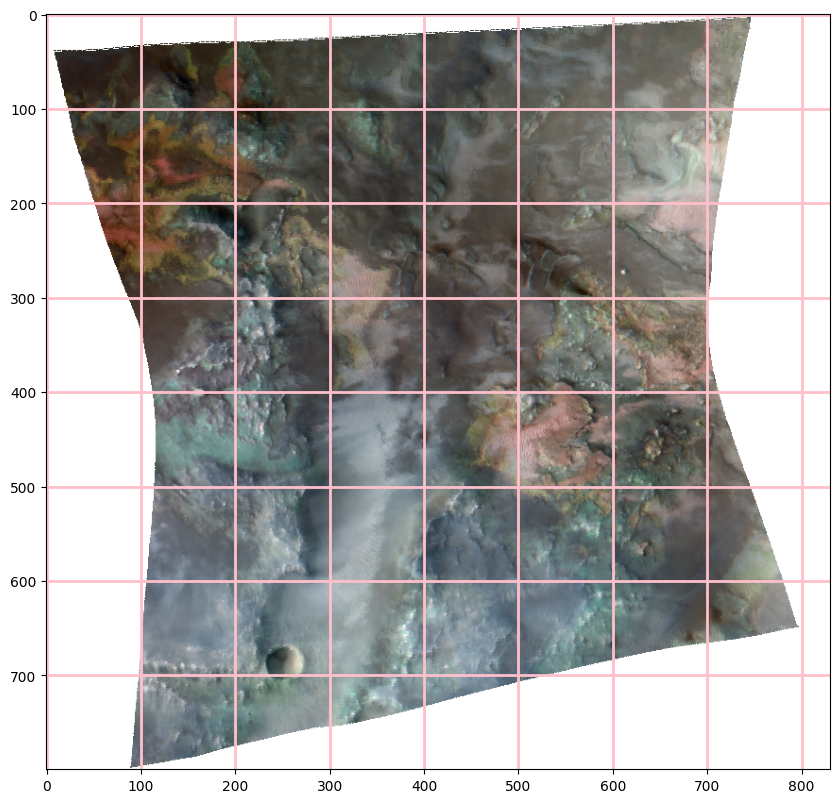

In [49]:
#set the band numbers to make the FCC
FCCBands=[13,78,233]
FCCBands.reverse()
#create FCC stack
FCCStack=datacube[:,:,FCCBands]
for i in range(FCCStack.shape[2]):
    #save band to a temporary variable
    temp=FCCStack[:,:,i]
    #scale the values to the range
    temp=(temp-np.min(temp[~np.isnan(FCCStack[:,:,i])]))/np.ptp(temp[~np.isnan(FCCStack[:,:,i])])
    temp[np.isnan(FCCStack[:,:,i])]=np.amax(temp[~np.isnan(FCCStack[:,:,i])])
    FCCStack[:,:,i]=temp
#display the FCC
baseFigureSize=10
plt.figure(figsize=(baseFigureSize*FCCStack.shape[1]/FCCStack.shape[0],baseFigureSize),dpi=100)
plt.imshow(FCCStack)
plt.grid(visible=True,
         which='both',
         lw=2,
         color='pink')

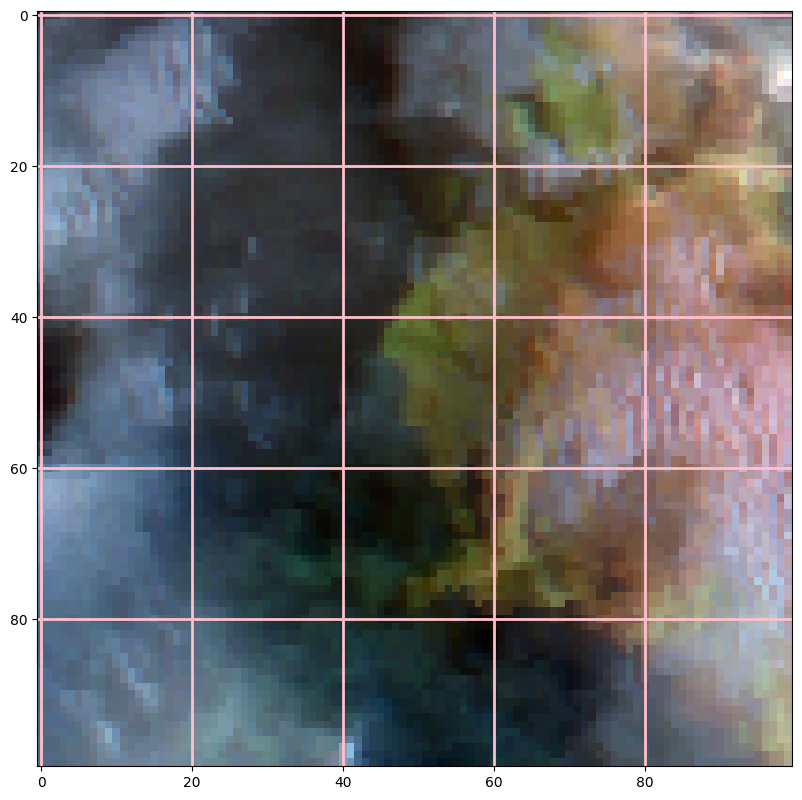

In [52]:
#set row and columns thresholds for zoomed image
rowLow=400
rowHigh=500
colLow=400
colHigh=500
#set the band numbers to make the FCC
FCCBands=[13,78,233]
FCCBands.reverse()
#create FCC stack
FCCStack=datacube[rowLow:rowHigh,colLow:colHigh,FCCBands]
for i in range(FCCStack.shape[2]):
    #save band to a temporary variable
    temp=FCCStack[:,:,i]
    #scale the values to the range
    temp=(temp-np.min(temp[~np.isnan(FCCStack[:,:,i])]))/np.ptp(temp[~np.isnan(FCCStack[:,:,i])])
    temp[np.isnan(FCCStack[:,:,i])]=np.amax(temp[~np.isnan(FCCStack[:,:,i])])
    FCCStack[:,:,i]=temp
#display the FCC
baseFigureSize=10
plt.figure(figsize=(baseFigureSize*FCCStack.shape[1]/FCCStack.shape[0],baseFigureSize),dpi=100)
plt.imshow(FCCStack)
plt.grid(visible=True,
         which='both',
         lw=2,
         color='pink')

C:\Users\104D\anaconda3\envs\geospatial\lib\site-packages\scipy\interpolate\_interpolate.py:641: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


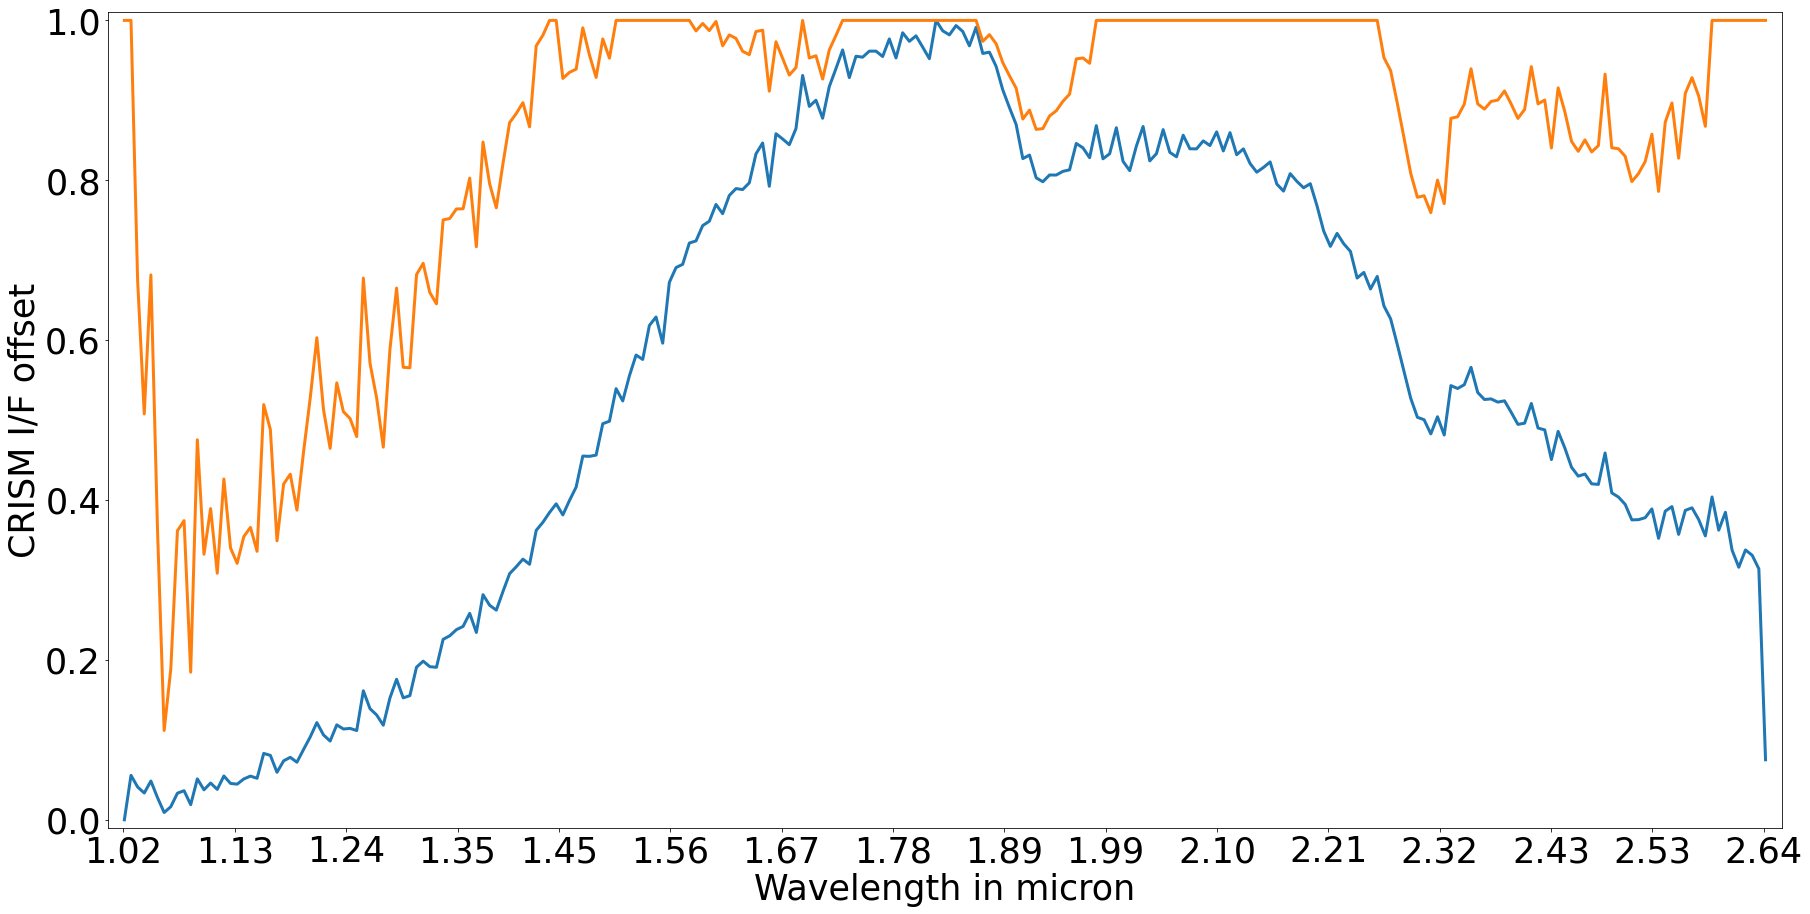

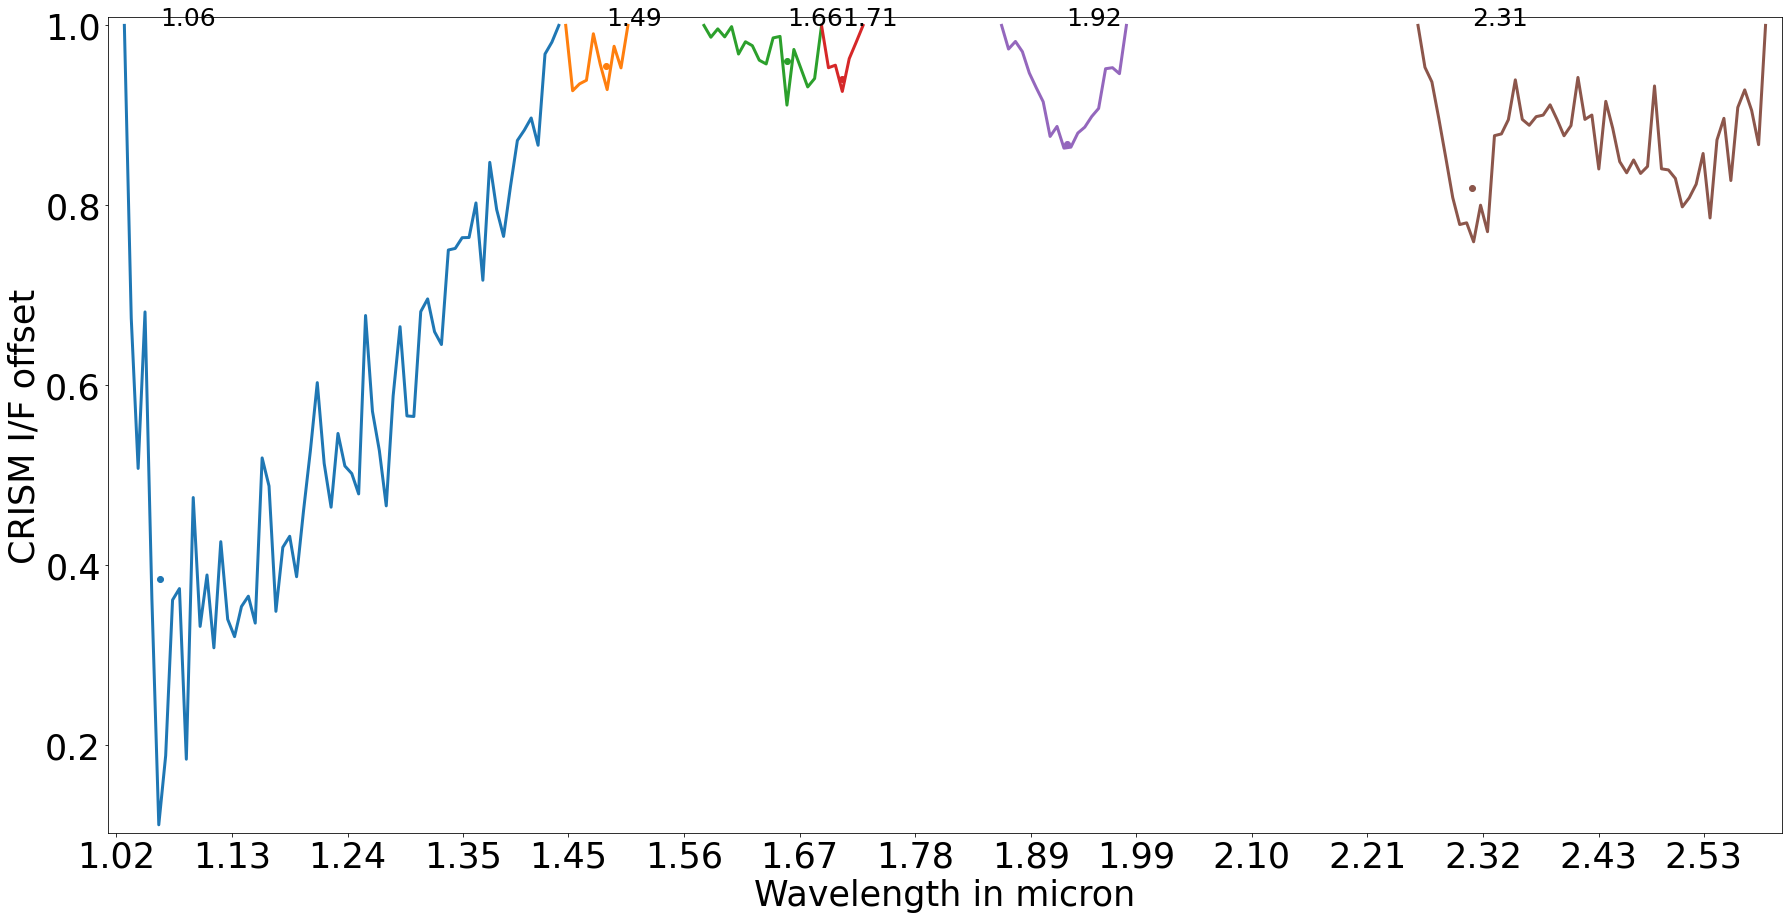

In [53]:
currentRowIndex=50
currentColIndex=50

#absoluteRowIndex=currentRowIndex+rowLowerBound
#absoluteColIndex=currentColIndex+colLowerBound

absoluteRowIndex=rowLow+currentRowIndex
absoluteColIndex=colLow+currentColIndex


currentSpectra=datacube[absoluteRowIndex,absoluteColIndex,:]
normalizedSpectra=normalizeSpectra(currentSpectra)
crSpectra,spectraHull=plotHullnCR(normalizedSpectra)
features,wavelengths=getAbsorptionFeatures(crSpectra)
bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)
    


plt.figure(figsize=(30,15))

wavelengthTicks=np.round(np.arange(wavelengthList[0],
                                   wavelengthList[-1]+(wavelengthList[-1]-wavelengthList[0])/15,
                                   (wavelengthList[-1]-wavelengthList[0])/15),2)
tickFontSize=35

plt.xticks(wavelengthTicks,fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.xlabel("Wavelength in micron",fontsize=tickFontSize)
plt.ylabel("CRISM I/F offset",fontsize=tickFontSize)

plt.plot(wavelengthList,
         normalizedSpectra,
         lw=3)

plt.plot(wavelengthList,
         crSpectra,
         lw=3)

plt.margins(x=0.01,
            y=0.01)


plt.figure(figsize=(30,15))

wavelengthTicks=np.round(np.arange(wavelengthList[0],
                                   wavelengthList[-1]+(wavelengthList[-1]-wavelengthList[0])/15,
                                   (wavelengthList[-1]-wavelengthList[0])/15),2)

plt.xticks(wavelengthTicks,fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.xlabel("Wavelength in micron",fontsize=tickFontSize)
plt.ylabel("CRISM I/F offset",fontsize=tickFontSize)

for i in range(len(features)):
    plt.plot(wavelengths[i],
             features[i],
             lw=3)
    
    plt.scatter(bandCentres[i],
                1-bandDepths[i])
    
    plt.text(bandCentres[i],
             1,
             str(round(bandCentres[i],2)),
             fontsize=tickFontSize-10)
    
plt.margins(x=0.01,
            y=0.01)